In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
import random

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model=128, n_heads=4, n_layers=2):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.size()
        tok_emb = self.token_emb(x)            
        x = tok_emb + self.pos_emb[:, :T, :]    
        x = x.transpose(0, 1)                   
        #mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(x.device)
        x = self.transformer(x,mask=None)                 # (T, B, d_model)
        x = x.transpose(0, 1)                  
        logits = self.lm_head(x)               
        return logits

class ToyDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=128):
        self.examples = []
        for text in texts:
            tokens = tokenizer.encode(text)
            for i in range(0, len(tokens) - seq_len):
                input_seq = tokens[i:i+seq_len]
                target_seq = tokens[i+1:i+seq_len+1]
                self.examples.append((input_seq, target_seq))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        x, y = self.examples[idx]
        return torch.tensor(x), torch.tensor(y)

def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def generate(model, tokenizer, prompt, max_new_tokens=50):
    model.eval()
    input_ids = tokenizer(prompt, return_tensors='pt')['input_ids'].to(next(model.parameters()).device)
    generated = input_ids

    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(generated)
            next_token_logits = logits[:, -1, :]
            probs = F.softmax(next_token_logits, dim=-1)
            #next_token = torch.multinomial(probs, num_samples=1) #randomness
            next_token = torch.argmax(probs, dim=-1, keepdim=True) #deterministic
            generated = torch.cat([generated, next_token], dim=1)

    return tokenizer.decode(generated[0])

if __name__ == "__main__":
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Dummy text data
    texts = ["Roy lives in Sweden.", "Roy is PhD student.", \
             "Roy works in Ericsson and Chalmers.", \
             "Roy has hobbies like tennis, guitar and video games."] * 20

    # Parameters
    seq_len = 8
    batch_size = 8
    vocab_size = tokenizer.vocab_size

    # DataLoader
    dataset = ToyDataset(texts, tokenizer, seq_len=seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model & Optimizer
    model = MiniGPT(vocab_size=vocab_size, seq_len=64).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

    # Training Loop
    losses = []
    epochs = 40
    for epoch in range(epochs):
        loss = train(model, dataloader, optimizer, device)
        losses.append(loss)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    prompt = "Roy has"
    output = generate(model, tokenizer, prompt, max_new_tokens=10)
    print("\nGenerated text:")
    print(output)

    prompt = "Roy works"
    output = generate(model, tokenizer, prompt, max_new_tokens=10)
    print("\nGenerated text:")
    print(output)

    prompt = "Introduce Roy:"
    output = generate(model, tokenizer, prompt, max_new_tokens=10)
    print("\nGenerated text:")
    print(output)

/home/eiinluj/phd/HA1_M1/dogcat1/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 8.6530
Epoch 2, Loss: 5.8627
Epoch 3, Loss: 4.6586
Epoch 4, Loss: 3.9997
Epoch 5, Loss: 3.4064
Epoch 6, Loss: 2.8734
Epoch 7, Loss: 2.3670
Epoch 8, Loss: 1.8982
Epoch 9, Loss: 1.4658
Epoch 10, Loss: 1.0886
Epoch 11, Loss: 0.7924
Epoch 12, Loss: 0.5707
Epoch 13, Loss: 0.4219
Epoch 14, Loss: 0.3139
Epoch 15, Loss: 0.2450
Epoch 16, Loss: 0.1952
Epoch 17, Loss: 0.1601
Epoch 18, Loss: 0.1347
Epoch 19, Loss: 0.1152
Epoch 20, Loss: 0.1021
Epoch 21, Loss: 0.0891
Epoch 22, Loss: 0.0799
Epoch 23, Loss: 0.0716
Epoch 24, Loss: 0.0652
Epoch 25, Loss: 0.0603
Epoch 26, Loss: 0.0552
Epoch 27, Loss: 0.0513
Epoch 28, Loss: 0.0476
Epoch 29, Loss: 0.0443
Epoch 30, Loss: 0.0414
Epoch 31, Loss: 0.0387
Epoch 32, Loss: 0.0366
Epoch 33, Loss: 0.0347
Epoch 34, Loss: 0.0328
Epoch 35, Loss: 0.0312
Epoch 36, Loss: 0.0294
Epoch 37, Loss: 0.0281
Epoch 38, Loss: 0.0267
Epoch 39, Loss: 0.0254
Epoch 40, Loss: 0.0244

Generated text:
Roy has hobbies like tennis, guitar and video games. video

Generated te

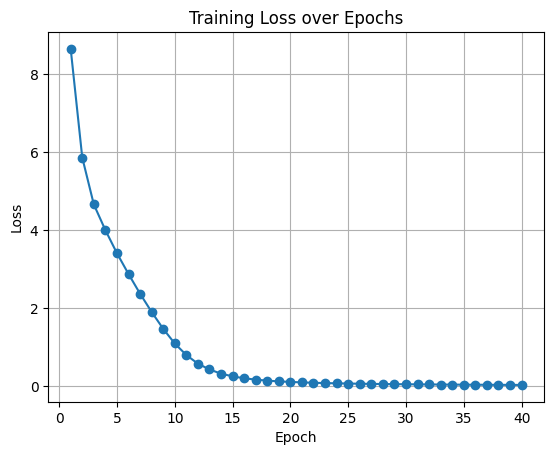

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()